# Train a 2D FBSEM net using brain web phantoms

Created on July 2020


Abi Mehranian
Email: abolfazl.mehranian@kcl.ac.uk


### 1- build datasets, see "build_training_sets.ipynb"
### 2- train the model

loaded in: 0.09886717796325684 sec.


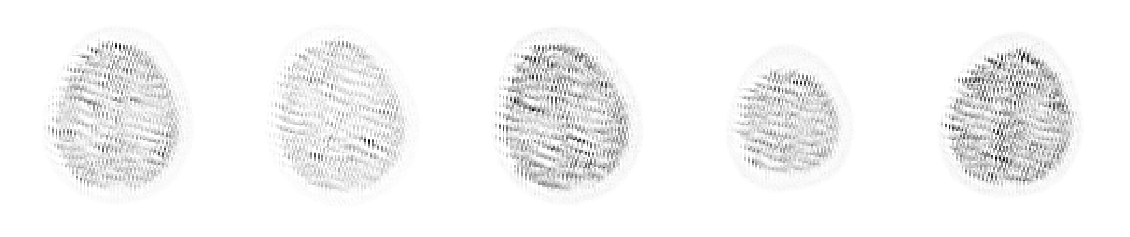

gamma: 0.31757110357284546


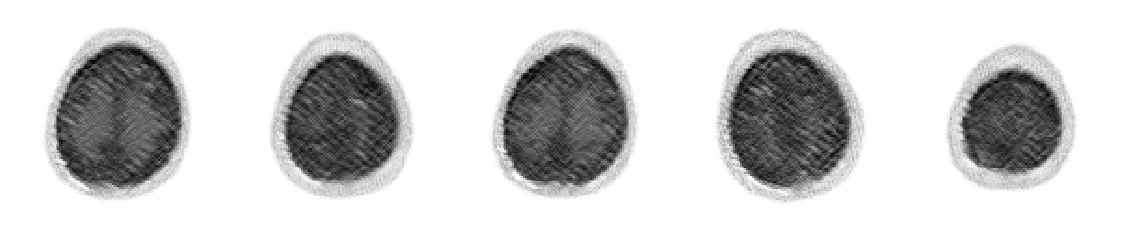

gamma: 0.30893605947494507


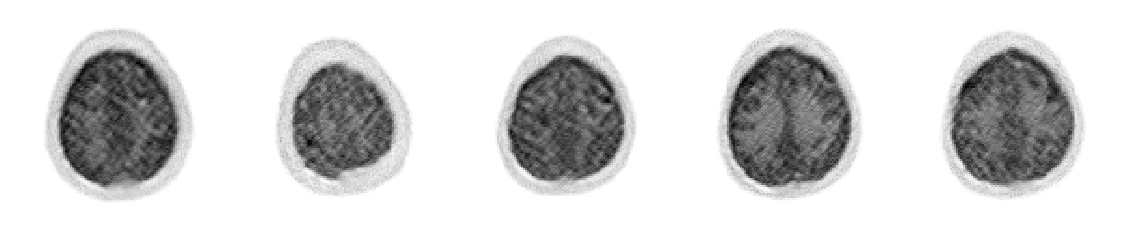

gamma: 0.3006954491138458


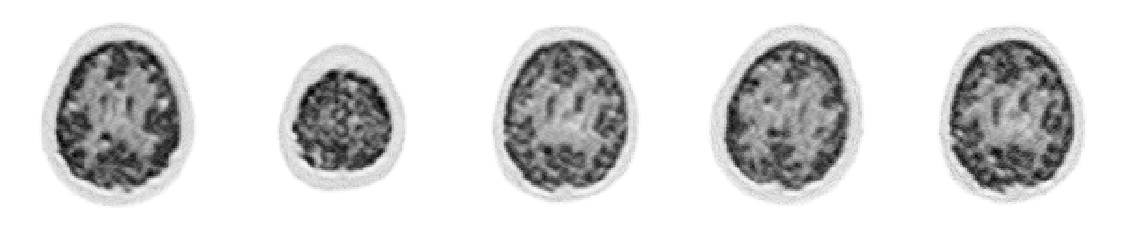

gamma: 0.2928504943847656


In [ ]:
import numpy as np
from geometry.BuildGeometry_v4 import BuildGeometry_v4
from models.deeplib import PETMrDataset, dotstruct, toNumpy, crop
from models.modellib import FBSEMnet_v3, Trainer, fbsemInference
import os
import torch

save_training_dir = r'C:\MoDL\trainingDatasets\brainweb\2D'

g = dotstruct()
g.is3d = False
g.temPath = r'C:\pythonWorkSpace\tmp003'
g.radialBinCropFactor = 0.5
g.psf_cm = 0.15
g.niters = 8
g.nsubs = 6
g.training_flname = [save_training_dir+os.sep,'data-']
g.save_dir = r'C:\MoDL\output\brainweb\2d'+os.sep
g.device ="cpu"
g.num_workers = 0
g.batch_size = 5
g.test_size = 0.2
g.valid_size = 0.1
g.num_train = 100
g.num_kernels=32
g.kernel_size=3
g.depth =5
g.in_channels = 2
g.reg_ccn_model = 'resUnit'
g.lr = 0.01
g.epochs = 50
g.model_name = 'fbsem-pm-03'
g.display = True
g.disp_figsize=(20,10)
g.save_from_epoch = 0
g.crop_factor = 0.3
g.do_validation = True



# build PET object
PET = BuildGeometry_v4('mmr',g.radialBinCropFactor)
PET.loadSystemMatrix(g.temPath,is3d=False )

# load dataloaders
train_loader, valid_loader, test_loader = PETMrDataset(g.training_flname, num_train=g.num_train, is3d=g.is3d, \
                                                       batch_size=g.batch_size, test_size=g.test_size, valid_size=g.valid_size, num_workers = g.num_workers)

# build model
model = FBSEMnet_v3(g.depth, g.num_kernels, g.kernel_size, g.in_channels, g.is3d, g.reg_ccn_model).to(g.device, dtype=torch.float32)

# train
Trainer(PET,model, g, train_loader, valid_loader)



### 3- FBSEM inference on test sets and comparsion with MAPEM

In [2]:
#FBSEM inference
dl_model_flname = r'C:\MoDL\output\brainweb\2d\fbsem-pm-03-epo-45.pth'
sinoLD, imgHD, AN, RS,imgLD, imgLD_psf, mrImg, counts, imgGT,_ = next(iter(test_loader))
img_fbsem = fbsemInference(dl_model_flname, PET, sinoLD, AN, mrImg, niters=10, nsubs =6)

# MAPEM reconstruction
sinoLD, imgHD, AN, imgLD, imgLD_psf, mrImg, imgGT = toNumpy(sinoLD), toNumpy(imgHD), toNumpy(AN), toNumpy(imgLD), toNumpy(imgLD_psf), toNumpy(mrImg), toNumpy(imgGT)

img_mapem = PET.mrMAPEM2DBatch(sinoLD,AN,mrImg,beta=0.06,niters = 10, nsubs=6,psf=0.15)


reconstructed in: 0.21667095025380453 min.
reconstructed in: 0.21744533777236938 min.
reconstructed in: 0.2158886988957723 min.
reconstructed in: 0.2135442058245341 min.
reconstructed in: 0.22433831294377646 min.


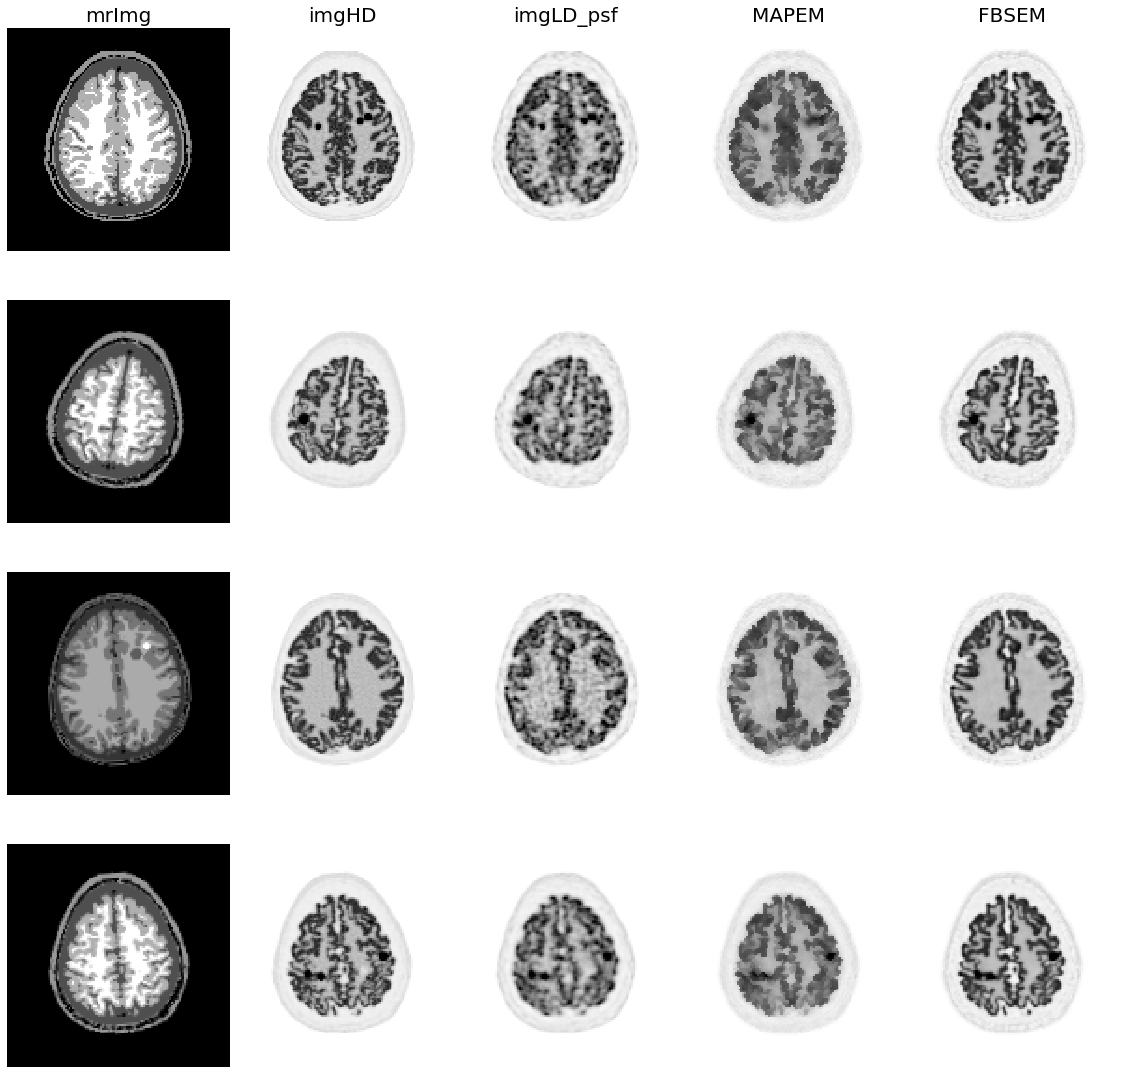

In [16]:
from matplotlib import pyplot as plt
vmax = 120
num_bathces = len(test_loader)
fig, ax = plt.subplots(num_bathces,5,figsize= (20,20),sharex=True, sharey=True)

for i in range(num_bathces):

    ax[i,0].imshow(crop(mrImg[i],0.3),cmap='gist_gray'),ax[i,0].axis('off')
    ax[i,1].imshow(crop(imgHD[i],0.3),cmap='gist_gray_r',vmax=vmax),ax[i,1].axis('off')
    ax[i,2].imshow(crop(imgLD_psf[i],0.3),cmap='gist_gray_r',vmax=vmax),ax[i,2].axis('off')
    ax[i,3].imshow(crop(img_mapem[i],0.3),cmap='gist_gray_r',vmax=vmax),ax[i,3].axis('off')
    ax[i,4].imshow(crop(img_fbsem[i],0.3),cmap='gist_gray_r',vmax=vmax),ax[i,4].axis('off')
    if i==0: 
        ax[i,0].set_title('mrImg',fontsize=20)
        ax[i,1].set_title('imgHD',fontsize=20)
        ax[i,2].set_title('imgLD_psf',fontsize=20)
        ax[i,3].set_title('MAPEM',fontsize=20)
        ax[i,4].set_title('FBSEM',fontsize=20)
fig.subplots_adjust(hspace=0,wspace=0)
